<a href="https://colab.research.google.com/github/Saksham9804/Projects/blob/main/Intraday_Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [67]:
# Importing all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import os
import yfinance as yf
from arch import arch_model
import pandas_ta as ta


In [68]:
# Setting up the plot style for better visualization
plt.style.use('ggplot')

##1. Loading simulated daily and 5-min data

In [69]:
# Loading simulated daily data
daily_df = pd.read_csv('/simulated_daily_data.csv')


In [70]:
# Converting Date column to datetime type
daily_df['Date'] = pd.to_datetime(daily_df['Date'])

In [71]:
# Setting Date column as index
daily_df = daily_df.set_index('Date')

In [72]:
# Calculating daily log returns
daily_df['log_ret'] = np.log(daily_df['Adj Close']).diff()

In [73]:
# Checking first few rows
daily_df.head()

,Open,High,Low,Close,Adj Close,Volume,Unnamed: 7,log_ret
Date,,,,,,,,
2014-09-17,116.466003,117.043503,113.105499,114.333504,114.333504,21056800.0,NaN,NaN
2014-09-18,114.214996,114.214996,103.276001,106.110001,106.110001,34483200.0,NaN,-0.074643
2014-09-19,106.025749,106.958748,96.133003,98.698998,98.698998,37919700.0,NaN,-0.072402
2014-09-20,98.668251,105.823998,97.470749,102.225998,102.225998,36863600.0,NaN,0.035111
2014-09-21,102.021248,103.106499,98.295250,99.705254,99.705254,26580100.0,NaN,-0.024968


In [74]:
# Checking data information and statistics
daily_df.info()
daily_df.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3289 entries, 2014-09-17 to 2023-09-18
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Open        3289 non-null   float64
 1   High        3289 non-null   float64
 2   Low         3289 non-null   float64
 3   Close       3289 non-null   float64
 4   Adj Close   3289 non-null   float64
 5   Volume      3289 non-null   float64
 6   Unnamed: 7  0 non-null      float64
 7   log_ret     3288 non-null   float64
dtypes: float64(8)
memory usage: 231.3 KB


,Open,High,Low,Close,Adj Close,Volume,Unnamed: 7,log_ret
count,3289.000000,3289.000000,3289.000000,3289.000000,3289.000000,3.289000e+03,0.0,3288.000000
mean,3481.234467,3564.151768,3390.327830,3482.898093,3482.898093,1.649486e+10,NaN,0.001238
std,3995.713262,4093.833160,3883.610589,3994.892110,3994.892110,1.932857e+10,NaN,0.037658
min,44.224251,52.932751,42.877499,44.525749,44.525749,5.914570e+06,NaN,-0.464730
25%,195.161743,198.127243,194.490494,196.226746,196.226746,1.361850e+08,NaN,-0.013020
50%,1989.072998,2041.638550,1939.732544,1990.831909,1990.831909,1.067880e+10,NaN,0.001333
75%,5381.613770,5451.227051,5241.146484,5383.530273,5383.530273,2.720560e+10,NaN,0.017055
max,16887.433590,17197.406250,16595.515630,16891.707030,16891.707030,3.509680e+11,NaN,0.225119


In [75]:
# Loading 5-min intraday simulated data
int_5min_df = pd.read_csv('/simulated_5min_data.csv')

In [76]:
# Converting datetime column to datetime object
int_5min_df['datetime'] = pd.to_datetime(int_5min_df['datetime'])

In [77]:
# Extracting date part for merging later
int_5min_df['date'] = int_5min_df['datetime'].dt.date

In [78]:
# Setting datetime column as index
int_5min_df = int_5min_df.set_index('datetime')

In [79]:
# Checking available columns in intraday dataframe
int_5min_df.columns

Index(['open', 'low', 'high', 'close', 'volume', 'Unnamed: 6', 'date'], dtype='object')

In [80]:
# Converting date column properly to datetime format again for safety
int_5min_df['date'] = pd.to_datetime(int_5min_df['date'])

In [81]:
# Checking the date part of the datetime index
int_5min_df['date'].index.date

array([datetime.date(2021, 9, 29), datetime.date(2021, 9, 29),
       datetime.date(2021, 9, 29), ..., datetime.date(2023, 9, 20),
       datetime.date(2023, 9, 20), datetime.date(2023, 9, 20)],
      shape=(177877,), dtype=object)

##2. Defining function to fit GARCH model and predict variance

In [82]:
# Calculating rolling 6-month variance of log returns
daily_df['variance'] = daily_df['log_ret'].rolling(180).var()

<Axes: xlabel='Date'>

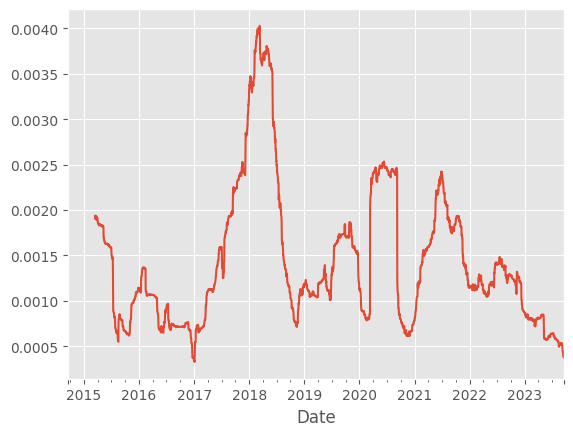

In [83]:
# Plotting rolling variance to visualize volatility dynamics
daily_df['variance'].plot()

In [84]:
# Filtering data starting from 2020 for analysis
daily_df = daily_df['2020-01-01':]

In [85]:
# Defining a prediction function to fit GARCH(1,3) and forecast next-day variance
def predict_volatility(x):
    # Fitting GARCH(1,3) model on rolling window data
    best_model = arch_model(y=x, p=1, q=3).fit(update_freq=5, disp='off')

In [86]:
# Defining a prediction function to fit GARCH(1,3) and forecast next-day variance
def predict_volatility(x):
    # Fitting GARCH(1,3) model on rolling window data
    best_model = arch_model(y=x, p=1, q=3).fit(update_freq=5, disp='off')

    # Forecasting 1-day ahead variance
    variance_forecast = best_model.forecast(horizon=1).variance.iloc[-1, 0]

    # Printing the current rolling window's latest date for tracking
    print(x.index[-1])

    # Returning the predicted variance
    return variance_forecast

In [87]:
# Applying the GARCH model on 6-month rolling window to get daily variance predictions
daily_df['predictions'] = daily_df['log_ret'].rolling(180).apply(lambda x: predict_volatility(x))

/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002459. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002459. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2020-06-28 00:00:00
2020-06-29 00:00:00
2020-06-30 00:00:00
2020-07-01 00:00:00
2020-07-02 00:00:00
2020-07-03 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00243. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002417. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:6

2020-07-04 00:00:00
2020-07-05 00:00:00
2020-07-06 00:00:00
2020-07-07 00:00:00
2020-07-08 00:00:00
2020-07-09 00:00:00
2020-07-10 00:00:00
2020-07-11 00:00:00
2020-07-12 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002415. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002413. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2020-07-13 00:00:00
2020-07-14 00:00:00
2020-07-15 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002377. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002374. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2020-07-16 00:00:00
2020-07-17 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00237. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00237. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)


2020-07-18 00:00:00
2020-07-19 00:00:00
2020-07-20 00:00:00
2020-07-21 00:00:00
2020-07-22 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002369. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002369. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2020-07-23 00:00:00
2020-07-24 00:00:00
2020-07-25 00:00:00
2020-07-26 00:00:00
2020-07-27 00:00:00
2020-07-28 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002363. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002357. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2020-07-29 00:00:00
2020-07-30 00:00:00
2020-07-31 00:00:00
2020-08-01 00:00:00
2020-08-02 00:00:00
2020-08-03 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002404. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002406. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2020-08-04 00:00:00
2020-08-05 00:00:00
2020-08-06 00:00:00
2020-08-07 00:00:00
2020-08-08 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002435. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002435. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2020-08-09 00:00:00
2020-08-10 00:00:00
2020-08-11 00:00:00
2020-08-12 00:00:00
2020-08-13 00:00:00
2020-08-14 00:00:00
2020-08-15 00:00:00
2020-08-16 00:00:00
2020-08-17 00:00:00
2020-08-18 00:00:00
2020-08-19 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002425. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002433. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2020-08-20 00:00:00
2020-08-21 00:00:00
2020-08-22 00:00:00
2020-08-23 00:00:00
2020-08-24 00:00:00
2020-08-25 00:00:00
2020-08-26 00:00:00
2020-08-27 00:00:00
2020-08-28 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002405. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002401. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2020-08-29 00:00:00
2020-08-30 00:00:00
2020-08-31 00:00:00
2020-09-01 00:00:00
2020-09-02 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00238. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002379. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:6

2020-09-03 00:00:00
2020-09-04 00:00:00
2020-09-05 00:00:00
2020-09-06 00:00:00
2020-09-07 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002404. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002408. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2020-09-08 00:00:00
2020-09-09 00:00:00
2020-09-10 00:00:00
2020-09-11 00:00:00
2020-09-12 00:00:00
2020-09-13 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001132. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001105. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2020-09-14 00:00:00
2020-09-15 00:00:00
2020-09-16 00:00:00
2020-09-17 00:00:00
2020-09-18 00:00:00
2020-09-19 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0009166. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0009175. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base

2020-09-20 00:00:00
2020-09-21 00:00:00
2020-09-22 00:00:00
2020-09-23 00:00:00
2020-09-24 00:00:00
2020-09-25 00:00:00
2020-09-26 00:00:00
2020-09-27 00:00:00
2020-09-28 00:00:00
2020-09-29 00:00:00
2020-09-30 00:00:00
2020-10-01 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008508. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008509. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base

2020-10-02 00:00:00
2020-10-03 00:00:00
2020-10-04 00:00:00
2020-10-05 00:00:00
2020-10-06 00:00:00
2020-10-07 00:00:00
2020-10-08 00:00:00
2020-10-09 00:00:00
2020-10-10 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007685. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007676. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base

2020-10-11 00:00:00
2020-10-12 00:00:00
2020-10-13 00:00:00
2020-10-14 00:00:00
2020-10-15 00:00:00
2020-10-16 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007415. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007183. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base

2020-10-17 00:00:00
2020-10-18 00:00:00
2020-10-19 00:00:00
2020-10-20 00:00:00
2020-10-21 00:00:00
2020-10-22 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007053. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007021. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base

2020-10-23 00:00:00
2020-10-24 00:00:00
2020-10-25 00:00:00
2020-10-26 00:00:00
2020-10-27 00:00:00
2020-10-28 00:00:00
2020-10-29 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007202. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007206. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base

2020-10-30 00:00:00
2020-10-31 00:00:00
2020-11-01 00:00:00
2020-11-02 00:00:00
2020-11-03 00:00:00
2020-11-04 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006547. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006545. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base

2020-11-05 00:00:00
2020-11-06 00:00:00
2020-11-07 00:00:00
2020-11-08 00:00:00
2020-11-09 00:00:00
2020-11-10 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006258. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000638. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.

2020-11-11 00:00:00
2020-11-12 00:00:00
2020-11-13 00:00:00
2020-11-14 00:00:00
2020-11-15 00:00:00
2020-11-16 00:00:00
2020-11-17 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006183. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000614. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.

2020-11-18 00:00:00
2020-11-19 00:00:00
2020-11-20 00:00:00
2020-11-21 00:00:00
2020-11-22 00:00:00
2020-11-23 00:00:00
2020-11-24 00:00:00
2020-11-25 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006234. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006182. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base

2020-11-26 00:00:00
2020-11-27 00:00:00
2020-11-28 00:00:00
2020-11-29 00:00:00
2020-11-30 00:00:00
2020-12-01 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000655. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006343. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.

2020-12-02 00:00:00
2020-12-03 00:00:00
2020-12-04 00:00:00
2020-12-05 00:00:00
2020-12-06 00:00:00
2020-12-07 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000652. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006619. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.

2020-12-08 00:00:00
2020-12-09 00:00:00
2020-12-10 00:00:00
2020-12-11 00:00:00
2020-12-12 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006579. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006599. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base

2020-12-13 00:00:00
2020-12-14 00:00:00
2020-12-15 00:00:00
2020-12-16 00:00:00
2020-12-17 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000668. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006675. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.

2020-12-18 00:00:00
2020-12-19 00:00:00
2020-12-20 00:00:00
2020-12-21 00:00:00
2020-12-22 00:00:00
2020-12-23 00:00:00
2020-12-24 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007376. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007405. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base

2020-12-25 00:00:00
2020-12-26 00:00:00
2020-12-27 00:00:00
2020-12-28 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007685. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007686. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base

2020-12-29 00:00:00
2020-12-30 00:00:00
2020-12-31 00:00:00
2021-01-01 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007816. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007816. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base

2021-01-02 00:00:00
2021-01-03 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000814. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/tmp/ipython-input-569826037.py:4: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  best_model = arch_model(y=x, p=1, q=3).fit(update_freq=5, disp='off')
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008189. Parameter
estimation work better when thi

2021-01-04 00:00:00
2021-01-05 00:00:00
2021-01-06 00:00:00
2021-01-07 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008323. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008613. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base

2021-01-08 00:00:00
2021-01-09 00:00:00
2021-01-10 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008857. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000903. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.

2021-01-11 00:00:00
2021-01-12 00:00:00
2021-01-13 00:00:00
2021-01-14 00:00:00
2021-01-15 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0009561. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0009987. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base

2021-01-16 00:00:00
2021-01-17 00:00:00
2021-01-18 00:00:00
2021-01-19 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001039. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001039. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2021-01-20 00:00:00
2021-01-21 00:00:00
2021-01-22 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001168. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001188. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2021-01-23 00:00:00
2021-01-24 00:00:00
2021-01-25 00:00:00
2021-01-26 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00114. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00114. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:69

2021-01-27 00:00:00
2021-01-28 00:00:00
2021-01-29 00:00:00
2021-01-30 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001184. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001183. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2021-01-31 00:00:00
2021-02-01 00:00:00
2021-02-02 00:00:00
2021-02-03 00:00:00
2021-02-04 00:00:00
2021-02-05 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001207. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001209. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2021-02-06 00:00:00
2021-02-07 00:00:00
2021-02-08 00:00:00
2021-02-09 00:00:00
2021-02-10 00:00:00
2021-02-11 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001353. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001363. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2021-02-12 00:00:00
2021-02-13 00:00:00
2021-02-14 00:00:00
2021-02-15 00:00:00
2021-02-16 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001378. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00138. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:6

2021-02-17 00:00:00
2021-02-18 00:00:00
2021-02-19 00:00:00
2021-02-20 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001417. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001407. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2021-02-21 00:00:00
2021-02-22 00:00:00
2021-02-23 00:00:00
2021-02-24 00:00:00
2021-02-25 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001522. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001524. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2021-02-26 00:00:00
2021-02-27 00:00:00
2021-02-28 00:00:00
2021-03-01 00:00:00
2021-03-02 00:00:00
2021-03-03 00:00:00
2021-03-04 00:00:00
2021-03-05 00:00:00
2021-03-06 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001493. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001493. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2021-03-07 00:00:00
2021-03-08 00:00:00
2021-03-09 00:00:00
2021-03-10 00:00:00
2021-03-11 00:00:00
2021-03-12 00:00:00
2021-03-13 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001507. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001507. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2021-03-14 00:00:00
2021-03-15 00:00:00
2021-03-16 00:00:00
2021-03-17 00:00:00
2021-03-18 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001563. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00156. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:6

2021-03-19 00:00:00
2021-03-20 00:00:00
2021-03-21 00:00:00
2021-03-22 00:00:00
2021-03-23 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001562. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001553. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2021-03-24 00:00:00
2021-03-25 00:00:00
2021-03-26 00:00:00
2021-03-27 00:00:00
2021-03-28 00:00:00
2021-03-29 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001584. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001584. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2021-03-30 00:00:00
2021-03-31 00:00:00
2021-04-01 00:00:00
2021-04-02 00:00:00
2021-04-03 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001582. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001591. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2021-04-04 00:00:00
2021-04-05 00:00:00
2021-04-06 00:00:00
2021-04-07 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001589. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001601. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2021-04-08 00:00:00
2021-04-09 00:00:00
2021-04-10 00:00:00
2021-04-11 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001608. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001606. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2021-04-12 00:00:00
2021-04-13 00:00:00
2021-04-14 00:00:00
2021-04-15 00:00:00
2021-04-16 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001618. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001618. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2021-04-17 00:00:00
2021-04-18 00:00:00
2021-04-19 00:00:00
2021-04-20 00:00:00
2021-04-21 00:00:00
2021-04-22 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001646. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001646. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2021-04-23 00:00:00
2021-04-24 00:00:00
2021-04-25 00:00:00
2021-04-26 00:00:00
2021-04-27 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001678. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001716. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2021-04-28 00:00:00
2021-04-29 00:00:00
2021-04-30 00:00:00
2021-05-01 00:00:00
2021-05-02 00:00:00
2021-05-03 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001747. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001744. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2021-05-04 00:00:00
2021-05-05 00:00:00
2021-05-06 00:00:00
2021-05-07 00:00:00
2021-05-08 00:00:00
2021-05-09 00:00:00
2021-05-10 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001745. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001739. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2021-05-11 00:00:00
2021-05-12 00:00:00
2021-05-13 00:00:00
2021-05-14 00:00:00
2021-05-15 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001868. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001868. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2021-05-16 00:00:00
2021-05-17 00:00:00
2021-05-18 00:00:00
2021-05-19 00:00:00
2021-05-20 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001903. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002023. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2021-05-21 00:00:00
2021-05-22 00:00:00
2021-05-23 00:00:00
2021-05-24 00:00:00
2021-05-25 00:00:00
2021-05-26 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002118. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002146. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2021-05-27 00:00:00
2021-05-28 00:00:00
2021-05-29 00:00:00
2021-05-30 00:00:00
2021-05-31 00:00:00
2021-06-01 00:00:00
2021-06-02 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002188. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002164. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2021-06-03 00:00:00
2021-06-04 00:00:00
2021-06-05 00:00:00
2021-06-06 00:00:00
2021-06-07 00:00:00
2021-06-08 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002188. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002196. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2021-06-09 00:00:00
2021-06-10 00:00:00
2021-06-11 00:00:00
2021-06-12 00:00:00
2021-06-13 00:00:00
2021-06-14 00:00:00
2021-06-15 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002263. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002263. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2021-06-16 00:00:00
2021-06-17 00:00:00
2021-06-18 00:00:00
2021-06-19 00:00:00
2021-06-20 00:00:00
2021-06-21 00:00:00
2021-06-22 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002273. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002294. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2021-06-23 00:00:00
2021-06-24 00:00:00
2021-06-25 00:00:00
2021-06-26 00:00:00
2021-06-27 00:00:00
2021-06-28 00:00:00
2021-06-29 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002337. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002384. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2021-06-30 00:00:00
2021-07-01 00:00:00
2021-07-02 00:00:00
2021-07-03 00:00:00
2021-07-04 00:00:00
2021-07-05 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002373. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002371. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2021-07-06 00:00:00
2021-07-07 00:00:00
2021-07-08 00:00:00
2021-07-09 00:00:00
2021-07-10 00:00:00
2021-07-11 00:00:00
2021-07-12 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002296. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002299. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2021-07-13 00:00:00
2021-07-14 00:00:00
2021-07-15 00:00:00
2021-07-16 00:00:00
2021-07-17 00:00:00
2021-07-18 00:00:00
2021-07-19 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002172. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002176. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2021-07-20 00:00:00
2021-07-21 00:00:00
2021-07-22 00:00:00
2021-07-23 00:00:00
2021-07-24 00:00:00
2021-07-25 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002075. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002071. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2021-07-26 00:00:00
2021-07-27 00:00:00
2021-07-28 00:00:00
2021-07-29 00:00:00
2021-07-30 00:00:00
2021-07-31 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002042. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00204. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:6

2021-08-01 00:00:00
2021-08-02 00:00:00
2021-08-03 00:00:00
2021-08-04 00:00:00
2021-08-05 00:00:00
2021-08-06 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002028. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002031. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2021-08-07 00:00:00
2021-08-08 00:00:00
2021-08-09 00:00:00
2021-08-10 00:00:00
2021-08-11 00:00:00
2021-08-12 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001891. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001903. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2021-08-13 00:00:00
2021-08-14 00:00:00
2021-08-15 00:00:00
2021-08-16 00:00:00
2021-08-17 00:00:00
2021-08-18 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001908. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001904. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2021-08-19 00:00:00
2021-08-20 00:00:00
2021-08-21 00:00:00
2021-08-22 00:00:00
2021-08-23 00:00:00
2021-08-24 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00188. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001861. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:6

2021-08-25 00:00:00
2021-08-26 00:00:00
2021-08-27 00:00:00
2021-08-28 00:00:00
2021-08-29 00:00:00
2021-08-30 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001803. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001811. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2021-08-31 00:00:00
2021-09-01 00:00:00
2021-09-02 00:00:00
2021-09-03 00:00:00
2021-09-04 00:00:00
2021-09-05 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001752. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001753. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2021-09-06 00:00:00
2021-09-07 00:00:00
2021-09-08 00:00:00
2021-09-09 00:00:00
2021-09-10 00:00:00
2021-09-11 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001802. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001803. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2021-09-12 00:00:00
2021-09-13 00:00:00
2021-09-14 00:00:00
2021-09-15 00:00:00
2021-09-16 00:00:00
2021-09-17 00:00:00
2021-09-18 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001757. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001768. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2021-09-19 00:00:00
2021-09-20 00:00:00
2021-09-21 00:00:00
2021-09-22 00:00:00
2021-09-23 00:00:00
2021-09-24 00:00:00
2021-09-25 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001805. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001817. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2021-09-26 00:00:00
2021-09-27 00:00:00
2021-09-28 00:00:00
2021-09-29 00:00:00
2021-09-30 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00183. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001834. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:6

2021-10-01 00:00:00
2021-10-02 00:00:00
2021-10-03 00:00:00
2021-10-04 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001895. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001895. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2021-10-05 00:00:00
2021-10-06 00:00:00
2021-10-07 00:00:00
2021-10-08 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001923. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001923. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2021-10-09 00:00:00
2021-10-10 00:00:00
2021-10-11 00:00:00
2021-10-12 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001905. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001918. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2021-10-13 00:00:00
2021-10-14 00:00:00
2021-10-15 00:00:00
2021-10-16 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00192. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001916. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:6

2021-10-17 00:00:00
2021-10-18 00:00:00
2021-10-19 00:00:00
2021-10-20 00:00:00
2021-10-21 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001904. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001901. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2021-10-22 00:00:00
2021-10-23 00:00:00
2021-10-24 00:00:00
2021-10-25 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001871. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001869. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2021-10-26 00:00:00
2021-10-27 00:00:00
2021-10-28 00:00:00
2021-10-29 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001857. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001864. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2021-10-30 00:00:00
2021-10-31 00:00:00
2021-11-01 00:00:00
2021-11-02 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001838. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001808. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2021-11-03 00:00:00
2021-11-04 00:00:00
2021-11-05 00:00:00
2021-11-06 00:00:00
2021-11-07 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001812. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001812. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2021-11-08 00:00:00
2021-11-09 00:00:00
2021-11-10 00:00:00
2021-11-11 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001712. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001718. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2021-11-12 00:00:00
2021-11-13 00:00:00
2021-11-14 00:00:00
2021-11-15 00:00:00
2021-11-16 00:00:00
2021-11-17 00:00:00
2021-11-18 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00167. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001669. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:6

2021-11-19 00:00:00
2021-11-20 00:00:00
2021-11-21 00:00:00
2021-11-22 00:00:00
2021-11-23 00:00:00
2021-11-24 00:00:00
2021-11-25 00:00:00
2021-11-26 00:00:00
2021-11-27 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0014. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001402. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:69

2021-11-28 00:00:00
2021-11-29 00:00:00
2021-11-30 00:00:00
2021-12-01 00:00:00
2021-12-02 00:00:00
2021-12-03 00:00:00
2021-12-04 00:00:00
2021-12-05 00:00:00
2021-12-06 00:00:00
2021-12-07 00:00:00
2021-12-08 00:00:00
2021-12-09 00:00:00
2021-12-10 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001395. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001387. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2021-12-11 00:00:00
2021-12-12 00:00:00
2021-12-13 00:00:00
2021-12-14 00:00:00
2021-12-15 00:00:00
2021-12-16 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001291. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001303. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2021-12-17 00:00:00
2021-12-18 00:00:00
2021-12-19 00:00:00
2021-12-20 00:00:00
2021-12-21 00:00:00
2021-12-22 00:00:00
2021-12-23 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001221. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001218. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2021-12-24 00:00:00
2021-12-25 00:00:00
2021-12-26 00:00:00
2021-12-27 00:00:00
2021-12-28 00:00:00
2021-12-29 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001149. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001141. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2021-12-30 00:00:00
2021-12-31 00:00:00
2022-01-01 00:00:00
2022-01-02 00:00:00
2022-01-03 00:00:00
2022-01-04 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001152. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001144. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2022-01-05 00:00:00
2022-01-06 00:00:00
2022-01-07 00:00:00
2022-01-08 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001153. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00116. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:6

2022-01-09 00:00:00
2022-01-10 00:00:00
2022-01-11 00:00:00
2022-01-12 00:00:00
2022-01-13 00:00:00
2022-01-14 00:00:00
2022-01-15 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001152. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001148. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2022-01-16 00:00:00
2022-01-17 00:00:00
2022-01-18 00:00:00
2022-01-19 00:00:00
2022-01-20 00:00:00
2022-01-21 00:00:00
2022-01-22 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001118. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001118. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2022-01-23 00:00:00
2022-01-24 00:00:00
2022-01-25 00:00:00
2022-01-26 00:00:00
2022-01-27 00:00:00
2022-01-28 00:00:00
2022-01-29 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001158. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001158. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2022-01-30 00:00:00
2022-01-31 00:00:00
2022-02-01 00:00:00
2022-02-02 00:00:00
2022-02-03 00:00:00
2022-02-04 00:00:00
2022-02-05 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00112. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001116. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:6

2022-02-06 00:00:00
2022-02-07 00:00:00
2022-02-08 00:00:00
2022-02-09 00:00:00
2022-02-10 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001164. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00116. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:6

2022-02-11 00:00:00
2022-02-12 00:00:00
2022-02-13 00:00:00
2022-02-14 00:00:00
2022-02-15 00:00:00
2022-02-16 00:00:00
2022-02-17 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001133. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001128. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2022-02-18 00:00:00
2022-02-19 00:00:00
2022-02-20 00:00:00
2022-02-21 00:00:00
2022-02-22 00:00:00
2022-02-23 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00115. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001152. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:6

2022-02-24 00:00:00
2022-02-25 00:00:00
2022-02-26 00:00:00
2022-02-27 00:00:00
2022-02-28 00:00:00
2022-03-01 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001152. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001144. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2022-03-02 00:00:00
2022-03-03 00:00:00
2022-03-04 00:00:00
2022-03-05 00:00:00
2022-03-06 00:00:00
2022-03-07 00:00:00
2022-03-08 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001257. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001285. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2022-03-09 00:00:00
2022-03-10 00:00:00
2022-03-11 00:00:00
2022-03-12 00:00:00
2022-03-13 00:00:00
2022-03-14 00:00:00
2022-03-15 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001265. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001264. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2022-03-16 00:00:00
2022-03-17 00:00:00
2022-03-18 00:00:00
2022-03-19 00:00:00
2022-03-20 00:00:00
2022-03-21 00:00:00
2022-03-22 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00127. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001271. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:6

2022-03-23 00:00:00
2022-03-24 00:00:00
2022-03-25 00:00:00
2022-03-26 00:00:00
2022-03-27 00:00:00
2022-03-28 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001173. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001172. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2022-03-29 00:00:00
2022-03-30 00:00:00
2022-03-31 00:00:00
2022-04-01 00:00:00
2022-04-02 00:00:00
2022-04-03 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001115. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00112. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:6

2022-04-04 00:00:00
2022-04-05 00:00:00
2022-04-06 00:00:00
2022-04-07 00:00:00
2022-04-08 00:00:00
2022-04-09 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001077. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001092. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2022-04-10 00:00:00
2022-04-11 00:00:00
2022-04-12 00:00:00
2022-04-13 00:00:00
2022-04-14 00:00:00
2022-04-15 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001098. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001099. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2022-04-16 00:00:00
2022-04-17 00:00:00
2022-04-18 00:00:00
2022-04-19 00:00:00
2022-04-20 00:00:00
2022-04-21 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001071. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001071. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2022-04-22 00:00:00
2022-04-23 00:00:00
2022-04-24 00:00:00
2022-04-25 00:00:00
2022-04-26 00:00:00
2022-04-27 00:00:00
2022-04-28 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001047. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001038. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2022-04-29 00:00:00
2022-04-30 00:00:00
2022-05-01 00:00:00
2022-05-02 00:00:00
2022-05-03 00:00:00
2022-05-04 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001056. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001051. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2022-05-05 00:00:00
2022-05-06 00:00:00
2022-05-07 00:00:00
2022-05-08 00:00:00
2022-05-09 00:00:00
2022-05-10 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001095. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00107. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:6

2022-05-11 00:00:00
2022-05-12 00:00:00
2022-05-13 00:00:00
2022-05-14 00:00:00
2022-05-15 00:00:00
2022-05-16 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001172. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001171. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2022-05-17 00:00:00
2022-05-18 00:00:00
2022-05-19 00:00:00
2022-05-20 00:00:00
2022-05-21 00:00:00
2022-05-22 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001178. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001192. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2022-05-23 00:00:00
2022-05-24 00:00:00
2022-05-25 00:00:00
2022-05-26 00:00:00
2022-05-27 00:00:00
2022-05-28 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001198. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001176. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2022-05-29 00:00:00
2022-05-30 00:00:00
2022-05-31 00:00:00
2022-06-01 00:00:00
2022-06-02 00:00:00
2022-06-03 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001198. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001198. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2022-06-04 00:00:00
2022-06-05 00:00:00
2022-06-06 00:00:00
2022-06-07 00:00:00
2022-06-08 00:00:00
2022-06-09 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00117. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001184. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:6

2022-06-10 00:00:00
2022-06-11 00:00:00
2022-06-12 00:00:00
2022-06-13 00:00:00
2022-06-14 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001141. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001158. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2022-06-15 00:00:00
2022-06-16 00:00:00
2022-06-17 00:00:00
2022-06-18 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001352. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001352. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2022-06-19 00:00:00
2022-06-20 00:00:00
2022-06-21 00:00:00
2022-06-22 00:00:00
2022-06-23 00:00:00
2022-06-24 00:00:00
2022-06-25 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001404. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001391. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2022-06-26 00:00:00
2022-06-27 00:00:00
2022-06-28 00:00:00
2022-06-29 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001399. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001398. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2022-06-30 00:00:00
2022-07-01 00:00:00
2022-07-02 00:00:00
2022-07-03 00:00:00
2022-07-04 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001394. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001393. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2022-07-05 00:00:00
2022-07-06 00:00:00
2022-07-07 00:00:00
2022-07-08 00:00:00
2022-07-09 00:00:00
2022-07-10 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001391. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001408. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2022-07-11 00:00:00
2022-07-12 00:00:00
2022-07-13 00:00:00
2022-07-14 00:00:00
2022-07-15 00:00:00
2022-07-16 00:00:00
2022-07-17 00:00:00
2022-07-18 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001413. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001425. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2022-07-19 00:00:00
2022-07-20 00:00:00
2022-07-21 00:00:00
2022-07-22 00:00:00
2022-07-23 00:00:00
2022-07-24 00:00:00
2022-07-25 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001412. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001405. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2022-07-26 00:00:00
2022-07-27 00:00:00
2022-07-28 00:00:00
2022-07-29 00:00:00
2022-07-30 00:00:00
2022-07-31 00:00:00
2022-08-01 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001446. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001455. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2022-08-02 00:00:00
2022-08-03 00:00:00
2022-08-04 00:00:00
2022-08-05 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001371. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001371. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2022-08-06 00:00:00
2022-08-07 00:00:00
2022-08-08 00:00:00
2022-08-09 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001371. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001374. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2022-08-10 00:00:00
2022-08-11 00:00:00
2022-08-12 00:00:00
2022-08-13 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001378. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001381. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2022-08-14 00:00:00
2022-08-15 00:00:00
2022-08-16 00:00:00
2022-08-17 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001366. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001333. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2022-08-18 00:00:00
2022-08-19 00:00:00
2022-08-20 00:00:00
2022-08-21 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001384. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00138. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:6

2022-08-22 00:00:00
2022-08-23 00:00:00
2022-08-24 00:00:00
2022-08-25 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001368. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001364. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2022-08-26 00:00:00
2022-08-27 00:00:00
2022-08-28 00:00:00
2022-08-29 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001271. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001267. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2022-08-30 00:00:00
2022-08-31 00:00:00
2022-09-01 00:00:00
2022-09-02 00:00:00
2022-09-03 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001241. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001241. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2022-09-04 00:00:00
2022-09-05 00:00:00
2022-09-06 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001197. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00119. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:6

2022-09-07 00:00:00
2022-09-08 00:00:00
2022-09-09 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001194. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001251. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2022-09-10 00:00:00
2022-09-11 00:00:00
2022-09-12 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001239. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001231. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2022-09-13 00:00:00
2022-09-14 00:00:00
2022-09-15 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001276. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001278. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2022-09-16 00:00:00
2022-09-17 00:00:00
2022-09-18 00:00:00
2022-09-19 00:00:00
2022-09-20 00:00:00
2022-09-21 00:00:00
2022-09-22 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001279. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001278. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2022-09-23 00:00:00
2022-09-24 00:00:00
2022-09-25 00:00:00
2022-09-26 00:00:00
2022-09-27 00:00:00
2022-09-28 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001274. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001273. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2022-09-29 00:00:00
2022-09-30 00:00:00
2022-10-01 00:00:00
2022-10-02 00:00:00
2022-10-03 00:00:00
2022-10-04 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001272. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001272. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2022-10-05 00:00:00
2022-10-06 00:00:00
2022-10-07 00:00:00
2022-10-08 00:00:00
2022-10-09 00:00:00
2022-10-10 00:00:00
2022-10-11 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001268. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001269. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2022-10-12 00:00:00
2022-10-13 00:00:00
2022-10-14 00:00:00
2022-10-15 00:00:00
2022-10-16 00:00:00
2022-10-17 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001238. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001237. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2022-10-18 00:00:00
2022-10-19 00:00:00
2022-10-20 00:00:00
2022-10-21 00:00:00
2022-10-22 00:00:00
2022-10-23 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00123. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00123. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:69

2022-10-24 00:00:00
2022-10-25 00:00:00
2022-10-26 00:00:00
2022-10-27 00:00:00
2022-10-28 00:00:00
2022-10-29 00:00:00
2022-10-30 00:00:00
2022-10-31 00:00:00
2022-11-01 00:00:00
2022-11-02 00:00:00
2022-11-03 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001214. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001218. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2022-11-04 00:00:00
2022-11-05 00:00:00
2022-11-06 00:00:00
2022-11-07 00:00:00
2022-11-08 00:00:00
2022-11-09 00:00:00
2022-11-10 00:00:00
2022-11-11 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001097. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001095. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2022-11-12 00:00:00
2022-11-13 00:00:00
2022-11-14 00:00:00
2022-11-15 00:00:00
2022-11-16 00:00:00
2022-11-17 00:00:00
2022-11-18 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001298. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001284. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2022-11-19 00:00:00
2022-11-20 00:00:00
2022-11-21 00:00:00
2022-11-22 00:00:00
2022-11-23 00:00:00
2022-11-24 00:00:00
2022-11-25 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001247. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001252. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2022-11-26 00:00:00
2022-11-27 00:00:00
2022-11-28 00:00:00
2022-11-29 00:00:00
2022-11-30 00:00:00
2022-12-01 00:00:00
2022-12-02 00:00:00
2022-12-03 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001221. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001201. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2022-12-04 00:00:00
2022-12-05 00:00:00
2022-12-06 00:00:00
2022-12-07 00:00:00
2022-12-08 00:00:00
2022-12-09 00:00:00
2022-12-10 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001192. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001192. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:

2022-12-11 00:00:00
2022-12-12 00:00:00
2022-12-13 00:00:00
2022-12-14 00:00:00
2022-12-15 00:00:00
2022-12-16 00:00:00
2022-12-17 00:00:00
2022-12-18 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001005. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0009544. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.p

2022-12-19 00:00:00
2022-12-20 00:00:00
2022-12-21 00:00:00
2022-12-22 00:00:00
2022-12-23 00:00:00
2022-12-24 00:00:00
2022-12-25 00:00:00
2022-12-26 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000887. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008867. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.

2022-12-27 00:00:00
2022-12-28 00:00:00
2022-12-29 00:00:00
2022-12-30 00:00:00
2022-12-31 00:00:00
2023-01-01 00:00:00
2023-01-02 00:00:00
2023-01-03 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000876. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008762. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.

2023-01-04 00:00:00
2023-01-05 00:00:00
2023-01-06 00:00:00
2023-01-07 00:00:00
2023-01-08 00:00:00
2023-01-09 00:00:00
2023-01-10 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008466. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008408. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base

2023-01-11 00:00:00
2023-01-12 00:00:00
2023-01-13 00:00:00
2023-01-14 00:00:00
2023-01-15 00:00:00
2023-01-16 00:00:00
2023-01-17 00:00:00
2023-01-18 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00083. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008442. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.p

2023-01-19 00:00:00
2023-01-20 00:00:00
2023-01-21 00:00:00
2023-01-22 00:00:00
2023-01-23 00:00:00
2023-01-24 00:00:00
2023-01-25 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008482. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008303. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base

2023-01-26 00:00:00
2023-01-27 00:00:00
2023-01-28 00:00:00
2023-01-29 00:00:00
2023-01-30 00:00:00
2023-01-31 00:00:00
2023-02-01 00:00:00
2023-02-02 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000792. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000792. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.p

2023-02-03 00:00:00
2023-02-04 00:00:00
2023-02-05 00:00:00
2023-02-06 00:00:00
2023-02-07 00:00:00
2023-02-08 00:00:00
2023-02-09 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007996. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007969. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base

2023-02-10 00:00:00
2023-02-11 00:00:00
2023-02-12 00:00:00
2023-02-13 00:00:00
2023-02-14 00:00:00
2023-02-15 00:00:00
2023-02-16 00:00:00
2023-02-17 00:00:00
2023-02-18 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008072. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008067. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base

2023-02-19 00:00:00
2023-02-20 00:00:00
2023-02-21 00:00:00
2023-02-22 00:00:00
2023-02-23 00:00:00
2023-02-24 00:00:00
2023-02-25 00:00:00
2023-02-26 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008003. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008015. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base

2023-02-27 00:00:00
2023-02-28 00:00:00
2023-03-01 00:00:00
2023-03-02 00:00:00
2023-03-03 00:00:00
2023-03-04 00:00:00
2023-03-05 00:00:00
2023-03-06 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007741. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000776. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.

2023-03-07 00:00:00
2023-03-08 00:00:00
2023-03-09 00:00:00
2023-03-10 00:00:00
2023-03-11 00:00:00
2023-03-12 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007189. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007408. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base

2023-03-13 00:00:00
2023-03-14 00:00:00
2023-03-15 00:00:00
2023-03-16 00:00:00
2023-03-17 00:00:00
2023-03-18 00:00:00
2023-03-19 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007556. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000757. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.

2023-03-20 00:00:00
2023-03-21 00:00:00
2023-03-22 00:00:00
2023-03-23 00:00:00
2023-03-24 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007864. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007922. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base

2023-03-25 00:00:00
2023-03-26 00:00:00
2023-03-27 00:00:00
2023-03-28 00:00:00
2023-03-29 00:00:00
2023-03-30 00:00:00
2023-03-31 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008007. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008056. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base

2023-04-01 00:00:00
2023-04-02 00:00:00
2023-04-03 00:00:00
2023-04-04 00:00:00
2023-04-05 00:00:00
2023-04-06 00:00:00
2023-04-07 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008027. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008036. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base

2023-04-08 00:00:00
2023-04-09 00:00:00
2023-04-10 00:00:00
2023-04-11 00:00:00
2023-04-12 00:00:00
2023-04-13 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007994. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008098. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base

2023-04-14 00:00:00
2023-04-15 00:00:00
2023-04-16 00:00:00
2023-04-17 00:00:00
2023-04-18 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008091. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008082. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base

2023-04-19 00:00:00
2023-04-20 00:00:00
2023-04-21 00:00:00
2023-04-22 00:00:00
2023-04-23 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008372. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008433. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base

2023-04-24 00:00:00
2023-04-25 00:00:00
2023-04-26 00:00:00
2023-04-27 00:00:00
2023-04-28 00:00:00
2023-04-29 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008323. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008313. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base

2023-04-30 00:00:00
2023-05-01 00:00:00
2023-05-02 00:00:00
2023-05-03 00:00:00
2023-05-04 00:00:00
2023-05-05 00:00:00
2023-05-06 00:00:00
2023-05-07 00:00:00
2023-05-08 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008452. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008472. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base

2023-05-09 00:00:00
2023-05-10 00:00:00
2023-05-11 00:00:00
2023-05-12 00:00:00
2023-05-13 00:00:00
2023-05-14 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005826. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005847. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base

2023-05-15 00:00:00
2023-05-16 00:00:00
2023-05-17 00:00:00
2023-05-18 00:00:00
2023-05-19 00:00:00
2023-05-20 00:00:00
2023-05-21 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005778. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005784. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base

2023-05-22 00:00:00
2023-05-23 00:00:00
2023-05-24 00:00:00
2023-05-25 00:00:00
2023-05-26 00:00:00
2023-05-27 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005673. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005741. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base

2023-05-28 00:00:00
2023-05-29 00:00:00
2023-05-30 00:00:00
2023-05-31 00:00:00
2023-06-01 00:00:00
2023-06-02 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005737. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005727. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base

2023-06-03 00:00:00
2023-06-04 00:00:00
2023-06-05 00:00:00
2023-06-06 00:00:00
2023-06-07 00:00:00
2023-06-08 00:00:00
2023-06-09 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005755. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005901. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base

2023-06-10 00:00:00
2023-06-11 00:00:00
2023-06-12 00:00:00
2023-06-13 00:00:00
2023-06-14 00:00:00
2023-06-15 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000609. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000609. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.p

2023-06-16 00:00:00
2023-06-17 00:00:00
2023-06-18 00:00:00
2023-06-19 00:00:00
2023-06-20 00:00:00
2023-06-21 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006023. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005992. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base

2023-06-22 00:00:00
2023-06-23 00:00:00
2023-06-24 00:00:00
2023-06-25 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006346. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006349. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base

2023-06-26 00:00:00
2023-06-27 00:00:00
2023-06-28 00:00:00
2023-06-29 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000634. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006368. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.

2023-06-30 00:00:00
2023-07-01 00:00:00
2023-07-02 00:00:00
2023-07-03 00:00:00
2023-07-04 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000637. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006369. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.

2023-07-05 00:00:00
2023-07-06 00:00:00
2023-07-07 00:00:00
2023-07-08 00:00:00
2023-07-09 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006426. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006431. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base

2023-07-10 00:00:00
2023-07-11 00:00:00
2023-07-12 00:00:00
2023-07-13 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006268. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006129. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base

2023-07-14 00:00:00
2023-07-15 00:00:00
2023-07-16 00:00:00
2023-07-17 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006125. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006126. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base

2023-07-18 00:00:00
2023-07-19 00:00:00
2023-07-20 00:00:00
2023-07-21 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005806. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005807. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base

2023-07-22 00:00:00
2023-07-23 00:00:00
2023-07-24 00:00:00
2023-07-25 00:00:00
2023-07-26 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005797. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005833. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base

2023-07-27 00:00:00
2023-07-28 00:00:00
2023-07-29 00:00:00
2023-07-30 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005782. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005687. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base

2023-07-31 00:00:00
2023-08-01 00:00:00
2023-08-02 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005653. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005673. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base

2023-08-03 00:00:00
2023-08-04 00:00:00
2023-08-05 00:00:00
2023-08-06 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005655. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000565. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.

2023-08-07 00:00:00
2023-08-08 00:00:00
2023-08-09 00:00:00
2023-08-10 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005484. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005484. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base

2023-08-11 00:00:00
2023-08-12 00:00:00
2023-08-13 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005481. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005466. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base

2023-08-14 00:00:00
2023-08-15 00:00:00
2023-08-16 00:00:00
2023-08-17 00:00:00
2023-08-18 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0004988. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0004924. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base

2023-08-19 00:00:00
2023-08-20 00:00:00
2023-08-21 00:00:00
2023-08-22 00:00:00
2023-08-23 00:00:00
2023-08-24 00:00:00
2023-08-25 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005215. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005209. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base

2023-08-26 00:00:00
2023-08-27 00:00:00
2023-08-28 00:00:00
2023-08-29 00:00:00
2023-08-30 00:00:00
2023-08-31 00:00:00
2023-09-01 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005136. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005112. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base

2023-09-02 00:00:00
2023-09-03 00:00:00
2023-09-04 00:00:00
2023-09-05 00:00:00
2023-09-06 00:00:00
2023-09-07 00:00:00
2023-09-08 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005333. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005304. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base

2023-09-09 00:00:00
2023-09-10 00:00:00
2023-09-11 00:00:00
2023-09-12 00:00:00
2023-09-13 00:00:00
2023-09-14 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000434. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0004366. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.

2023-09-15 00:00:00
2023-09-16 00:00:00
2023-09-17 00:00:00
2023-09-18 00:00:00


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003823. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003811. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base

<Axes: xlabel='Date'>

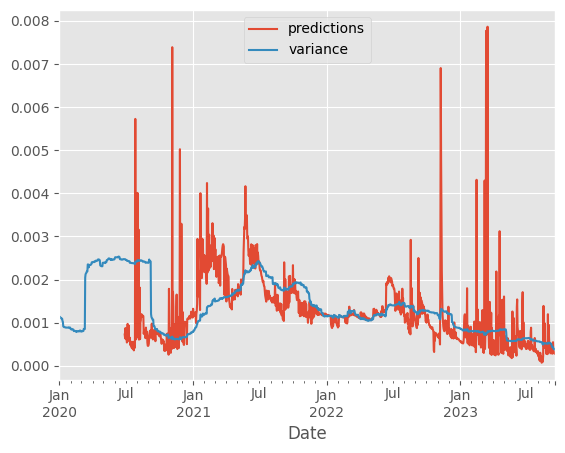

In [88]:
# Plotting predicted vs actual variance
daily_df[['predictions', 'variance']].plot()

## 3. Calculating prediction premium and daily signal

In [89]:
# Calculating prediction premium as relative difference between predicted and actual variance
daily_df['prediction_premium'] = (daily_df['predictions'] - daily_df['variance']) / daily_df['variance']

In [90]:
# Calculating rolling 6-month standard deviation of prediction premium
daily_df['premium_std'] = daily_df['prediction_premium'].rolling(180).std()

<Axes: xlabel='Date'>

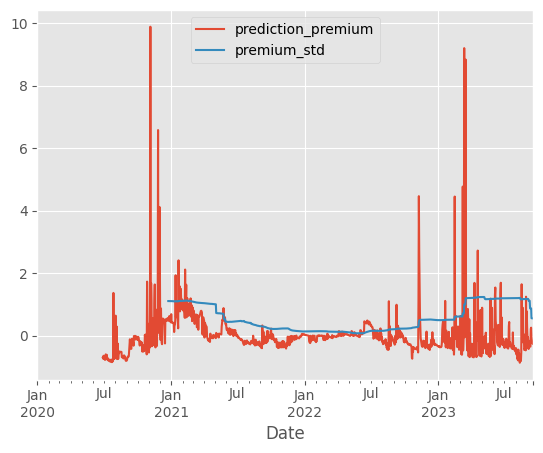

In [91]:
# Plotting prediction premium and its rolling standard deviation
daily_df[['prediction_premium', 'premium_std']].plot()

In [92]:
# Creating daily trading signal based on prediction premium thresholds
daily_df['signal_daily'] = daily_df.apply(
    lambda x: 1 if (x['prediction_premium'] > x['premium_std'] * 1.5)
    else (-1 if (x['prediction_premium'] < x['premium_std'] * -1.5) else np.nan),
    axis=1
)

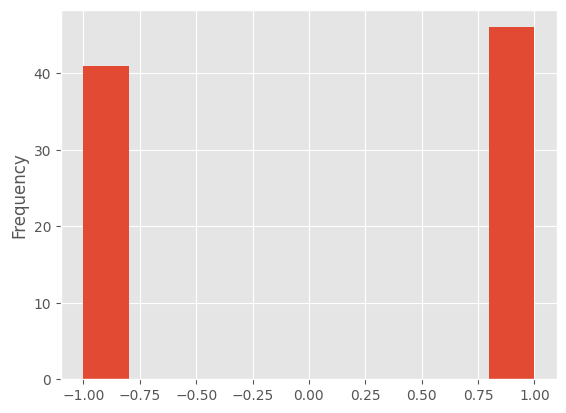

In [93]:
# Plotting histogram of generated daily signals
daily_df['signal_daily'].plot(kind='hist')
plt.show()

In [94]:
# Shifting the daily signal by one day to avoid lookahead bias
daily_df['signal_daily'] = daily_df['signal_daily'].shift()


## 4. Merging daily signals with intraday data and generating RSI

In [95]:
# Merging intraday dataframe with daily signal using date as key
final_df = int_5min_df.reset_index().merge(
    daily_df[['signal_daily']].reset_index(),
    left_on='date',
    right_on='Date'
)

In [96]:
# Dropping redundant date columns after merging
final_df = final_df.drop(['date', 'Date'], axis=1)

In [97]:
# Checking final merged columns
final_df.columns

Index(['datetime', 'open', 'low', 'high', 'close', 'volume', 'Unnamed: 6',
       'signal_daily'],
      dtype='object')

In [98]:
# Calculating RSI with 20-period window on intraday close price
final_df['rsi'] = ta.rsi(close=final_df['close'], length=20)

In [99]:
# Calculating Bollinger Bands for 20-periods
final_df['lband'] = ta.bbands(close=final_df['close'], length=20).iloc[:, 0]
final_df['uband'] = ta.bbands(close=final_df['close'], length=20).iloc[:, 2]

In [100]:
# Creating intraday signal based on RSI and Bollinger Band conditions
final_df['signal_intraday'] = final_df.apply(
    lambda x: 1 if (x['rsi'] > 70) & (x['close'] > x['uband'])
    else (-1 if (x['rsi'] < 30) & (x['close'] < x['lband']) else np.nan),
    axis=1
)

In [101]:
# Inspecting merged dataframe structure and datatypes
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177456 entries, 0 to 177455
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   datetime         177456 non-null  datetime64[ns]
 1   open             177456 non-null  float64       
 2   low              177456 non-null  float64       
 3   high             177456 non-null  float64       
 4   close            177456 non-null  float64       
 5   volume           177456 non-null  int64         
 6   Unnamed: 6       0 non-null       float64       
 7   signal_daily     20460 non-null   float64       
 8   rsi              177455 non-null  float64       
 9   lband            177437 non-null  float64       
 10  uband            177437 non-null  float64       
 11  signal_intraday  3179 non-null    float64       
dtypes: datetime64[ns](1), float64(10), int64(1)
memory usage: 16.2 MB


## 5. Generating position entry and calculating returns

In [102]:
# Combining daily and intraday signals to form return direction
final_df['return_sign'] = final_df.apply(
    lambda x: -1 if (x['signal_daily'] == 1) & (x['signal_intraday'] == 1)
    else (1 if (x['signal_daily'] == -1) & (x['signal_intraday'] == -1) else np.nan),
    axis=1
)

In [103]:
# Calculating 5-min percentage returns on close price
final_df['return'] = final_df['close'].pct_change()
final_df['forward_return']=final_df['return'].shift(-1)

In [104]:
# Calculating strategy returns based on signal alignment
final_df['strategy_return'] = final_df['forward_return'] * final_df['return_sign']

In [105]:
# Setting datetime as dataframe index again
final_df = final_df.set_index('datetime')

In [106]:
# Aggregating strategy returns at daily level
daily_return_df = final_df.groupby(pd.Grouper(freq='D'))[['strategy_return']].sum()

##6. Plotting final strategy returns

In [107]:
import matplotlib.ticker as mtick

In [108]:
#Calculating cumulative strategy return
strategy_cumlative_return = (1 + daily_return_df['strategy_return']).cumprod() - 1

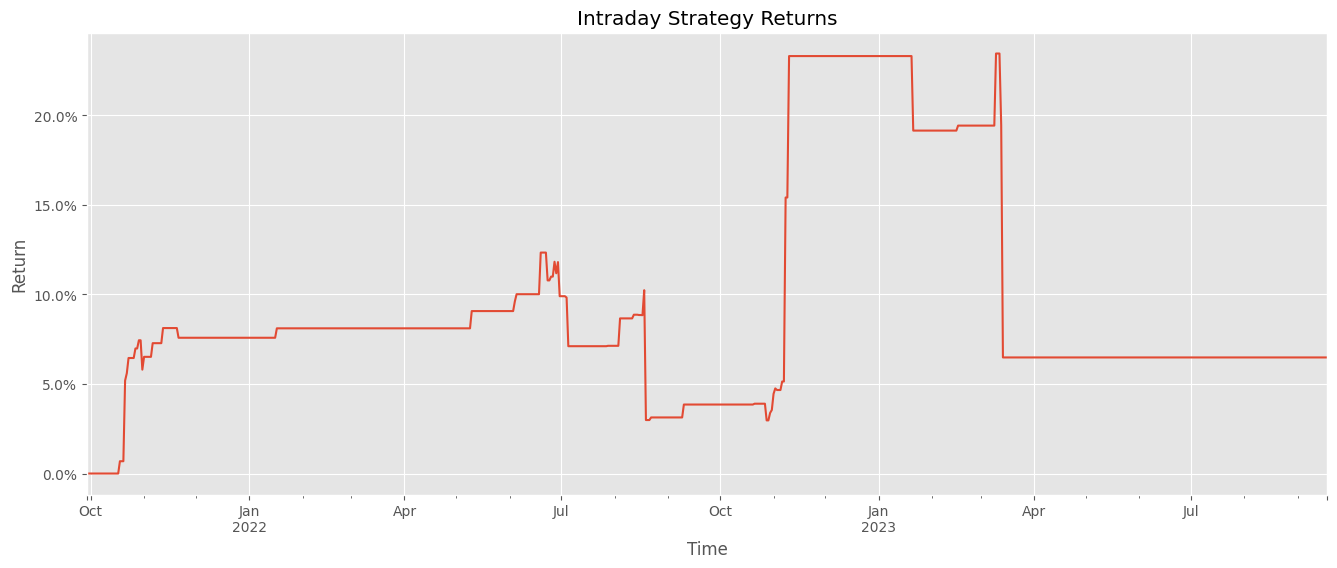

In [111]:
# Plotting cumulative intraday strategy performance
fig, ax = plt.subplots(figsize=(16, 6))
strategy_cumlative_return.plot(ax=ax)
ax.set_title('Intraday Strategy Returns')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=0.4))
ax.set_ylabel('Return')
ax.set_xlabel('Time')
plt.show()